# Import libraries

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from time import perf_counter
import os
import sys
import joblib
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import spacy
nlp = spacy.load('en_core_web_lg')

from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC, SVC
    
from ml.plot import plot_confusion_matrices, category_histogram
from ml.words import lemmatize_df
from ml.hypertuning import find_best_parameters
from ml.models import save_model

# Extract data

The data will be downloaded from S3 and stored in a specified folder. The user will be prompted for the password.

In [ ]:
from ml.data import download_data

data_folder = 'data'

download_data(data_folder=data_folder)

# Data Cleaning

In [3]:
df = pd.read_csv(data_folder + '/data_redacted.tsv', sep='\t')
print(df.shape)
df.head()

(8646, 4)


,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but perhaps that wouldn""t be so bad. Whether a mammal is a male or a female usually comes down to its set of sex chromosomes, either XX if you’re female, or XY, male. But studies have shown the human Y chromosome has degraded over time, losing up to 1,600 genes in about 200 million years, by some estimates. More strikingly, some mammals, such as the Japanese spiny rat, have shed their Y chromosomes altogether. “So what is to stop the human Y from disappearing?” says evolutionary geneticist and molecular biologist Jennifer Marshall Graves of La Trobe University. She contends that the Y chromosome already starts at a disadvantage: Unlike the X, it has no partner for genetic recombination (the random exchange of segments between chromosome pairs), so it can accumulate harmful mutations, leaving it perennially vulnerable. She says the human Y should disappear in about 4.6 million years if its degradation continues at the rate it’s happened so far — and there’s no reason it has to take that long. Sudden changes have sparked previous losses in the Y, so we always could lose our Y much sooner. But let’s be clear: A vanishing Y does not mean vanishing males. Instead, Graves suggests that a new sex-determining system could evolve, as it did for the spiny rats. Instead of XY or XX, male and female rats are both XO, meaning they have a single unpaired X chromosome; an unknown spot in the genetic code now determines the gender. The same could happen to humans, with some novel genetic mutation usurping the Y chromosome’s role. Not everyone agrees, of course. “I am convinced that the Y genes are too important to be lost, and the situation in spiny rats is probably just an isolated situation,” says biologist Jennifer Hughes of the Whitehead Institute at MIT. She and others note that the Y has been able to keep its important genes through “purifying selection,” in which deleterious changes are removed over time. Graves realizes our Y may not disappear tomorrow — or ever. Her point is that it could fade away, given its degraded history. Unless it starts to happen soon, we’ll just have to live in suspense.",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-transactions says game industry source,"Bungie is putting together plans to start selling ammo packs for real world money in its hit online shooter Destiny, according to a new report. It is said that ammo packs will be sold for Silver – the in-game currency bought with real world money. VG247""s report states: ""Bungie is to sell Destiny ammo packs for real money, a source familiar with the matter has confirmed to VG247. Micro-transactions were introduced to Destiny in October 2015, with players able to buy Silver to spend on emotes and items for a player""s Sparrow vehicle. If ammo packs were to be sold, it would mark the first time items that directly affect gameplay will have been sold – setting Bungie and Destiny down a path many fans would not be happy about. It would mean players are able to stock up on ammo easily (for a price) when they tackle co-op Raids, where heavy ammo is especially useful. Buying such ammo wouldn""t affect the player vs player aspect of Destiny however. There""s no information yet regarding how much ammo packs – which come in three varieties for each of the game""s three weapon slots – might cost. Currently players are able to find ammo that is dropped by downed enemies, or through buying ammo with glimmer – Destiny""s free in-game currency. If Bungie do start selling ammo packs for real money, it""ll be interesting to see if there is any change to the frequency of heavy ammo drops in particular. Since the game was first released in 2014, the spectre of micro-transactions has loomed over the franchise. With no expansion packs planned for release in 2016 , with the October introduction of micro-paymen

Almost 9000 rows. No RNN techniques will be attempted because of having now enough rows of data.

In [4]:
for column in df.columns:
    string_lengths = df[column].apply(len)
    print(f'Column: {column}, minimum length: {string_lengths.min()}, maximum length: {string_lengths.max()}')

Column: title, minimum length: 3, maximum length: 447
Column: text, minimum length: 122, maximum length: 38390
Column: url, minimum length: 27, maximum length: 413
Column: category, minimum length: 4, maximum length: 24


Every row on every column has a positive minimum length. The database doesn't have null rows.

However, there are titles with only 3 letters. Checking them out:



In [5]:
df['len_title'] = df.title.apply(len)
df.sort_values('len_title').head(3)

title  \
922    Cam   
5334  Reks   
3562  R400   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Particular titles. However, they seem valid.

Let's check the distribution of categories:

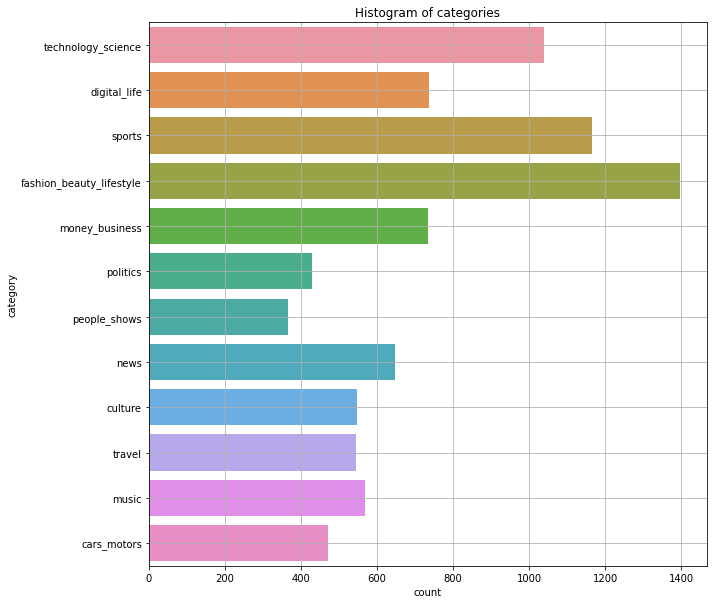

In [6]:
category_histogram(df)

There is imbalance of catefories. A weight balancing approach will 

To get data for a model, title and text will be combined and then lemmatized using Spacy.

In [7]:
df = lemmatize_df(df)
df.head()

,title,text,url,category,len_title,lemmatized_text
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but perhaps that wouldn""t be so bad. Whether a mammal is a male or a female usually comes down to its set of sex chromosomes, either XX if you’re female, or XY, male. But studies have shown the human Y chromosome has degraded over time, losing up to 1,600 genes in about 200 million years, by some estimates. More strikingly, some mammals, such as the Japanese spiny rat, have shed their Y chromosomes altogether. “So what is to stop the human Y from disappearing?” says evolutionary geneticist and molecular biologist Jennifer Marshall Graves of La Trobe University. She contends that the Y chromosome already starts at a disadvantage: Unlike the X, it has no partner for genetic recombination (the random exchange of segments between chromosome pairs), so it can accumulate harmful mutations, leaving it perennially vulnerable. She says the human Y should disappear in about 4.6 million years if its degradation continues at the rate it’s happened so far — and there’s no reason it has to take that long. Sudden changes have sparked previous losses in the Y, so we always could lose our Y much sooner. But let’s be clear: A vanishing Y does not mean vanishing males. Instead, Graves suggests that a new sex-determining system could evolve, as it did for the spiny rats. Instead of XY or XX, male and female rats are both XO, meaning they have a single unpaired X chromosome; an unknown spot in the genetic code now determines the gender. The same could happen to humans, with some novel genetic mutation usurping the Y chromosome’s role. Not everyone agrees, of course. “I am convinced that the Y genes are too important to be lost, and the situation in spiny rats is probably just an isolated situation,” says biologist Jennifer Hughes of the Whitehead Institute at MIT. She and others note that the Y has been able to keep its important genes through “purifying selection,” in which deleterious changes are removed over time. Graves realizes our Y may not disappear tomorrow — or ever. Her point is that it could fade away, given its degraded history. Unless it starts to happen soon, we’ll just have to live in suspense.",http://discovermagazine.com/2014/nov/13-y-not,technology_science,28,"don""t mourn y chromosome human y chromosome vanish day wouldn""t bad mammal male female usually come set sex chromosome xx female xy male study show human y chromosome degrade time lose 1,600 gene 200 million year estimate strikingly mammal japanese spiny rat shed y chromosome altogether stop human y disappear say evolutionary geneticist molecular biologist jennifer marshall graves la trobe university contend y chromosome start disadvantage unlike x partner genetic recombination random exchange segment chromosome pair accumulate harmful mutation leave perennially vulnerable say human y disappear 4.6 million year degradation continue rate happen far reason long sudden change spark previous loss y lose y soon let clear vanish y mean vanish male instead graves suggest new sex determine system evolve spiny rat instead xy xx male female rat xo mean single unpaired x chromosome unknown spot genetic code determine gender happen human novel genetic mutation usurp y chromosome role agree course convince y gene important lose situation spiny rat probably isolated situation say biologist jennifer hughes whitehead institute mit note y able important gene purify selection deleterious change remove time grave realize y disappear tomorrow point fade away give degraded history start happen soon live suspense"
1,Destiny: Bungie to introduce ammo pack micro-transactions says game industry source,"Bungie is putting together plans to start selling ammo packs for real world money in its hit online shooter Destiny, according to a new report. It is said that ammo packs will be sold for Silver – the in-game currency bought with real world money. VG247""s report states:

# Feature Extraction

Next, it would be interesting to check the distribution of categories using beautiful t-SNE.

For this, features will be made using Scikit-Learn's word vectorizer:

In [8]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2), stop_words='english')
dtm = tfidf.fit_transform(df.lemmatized_text)
dtm

<8646x25339 sparse matrix of type '<class 'numpy.float64'>'
	with 1682668 stored elements in Compressed Sparse Row format>

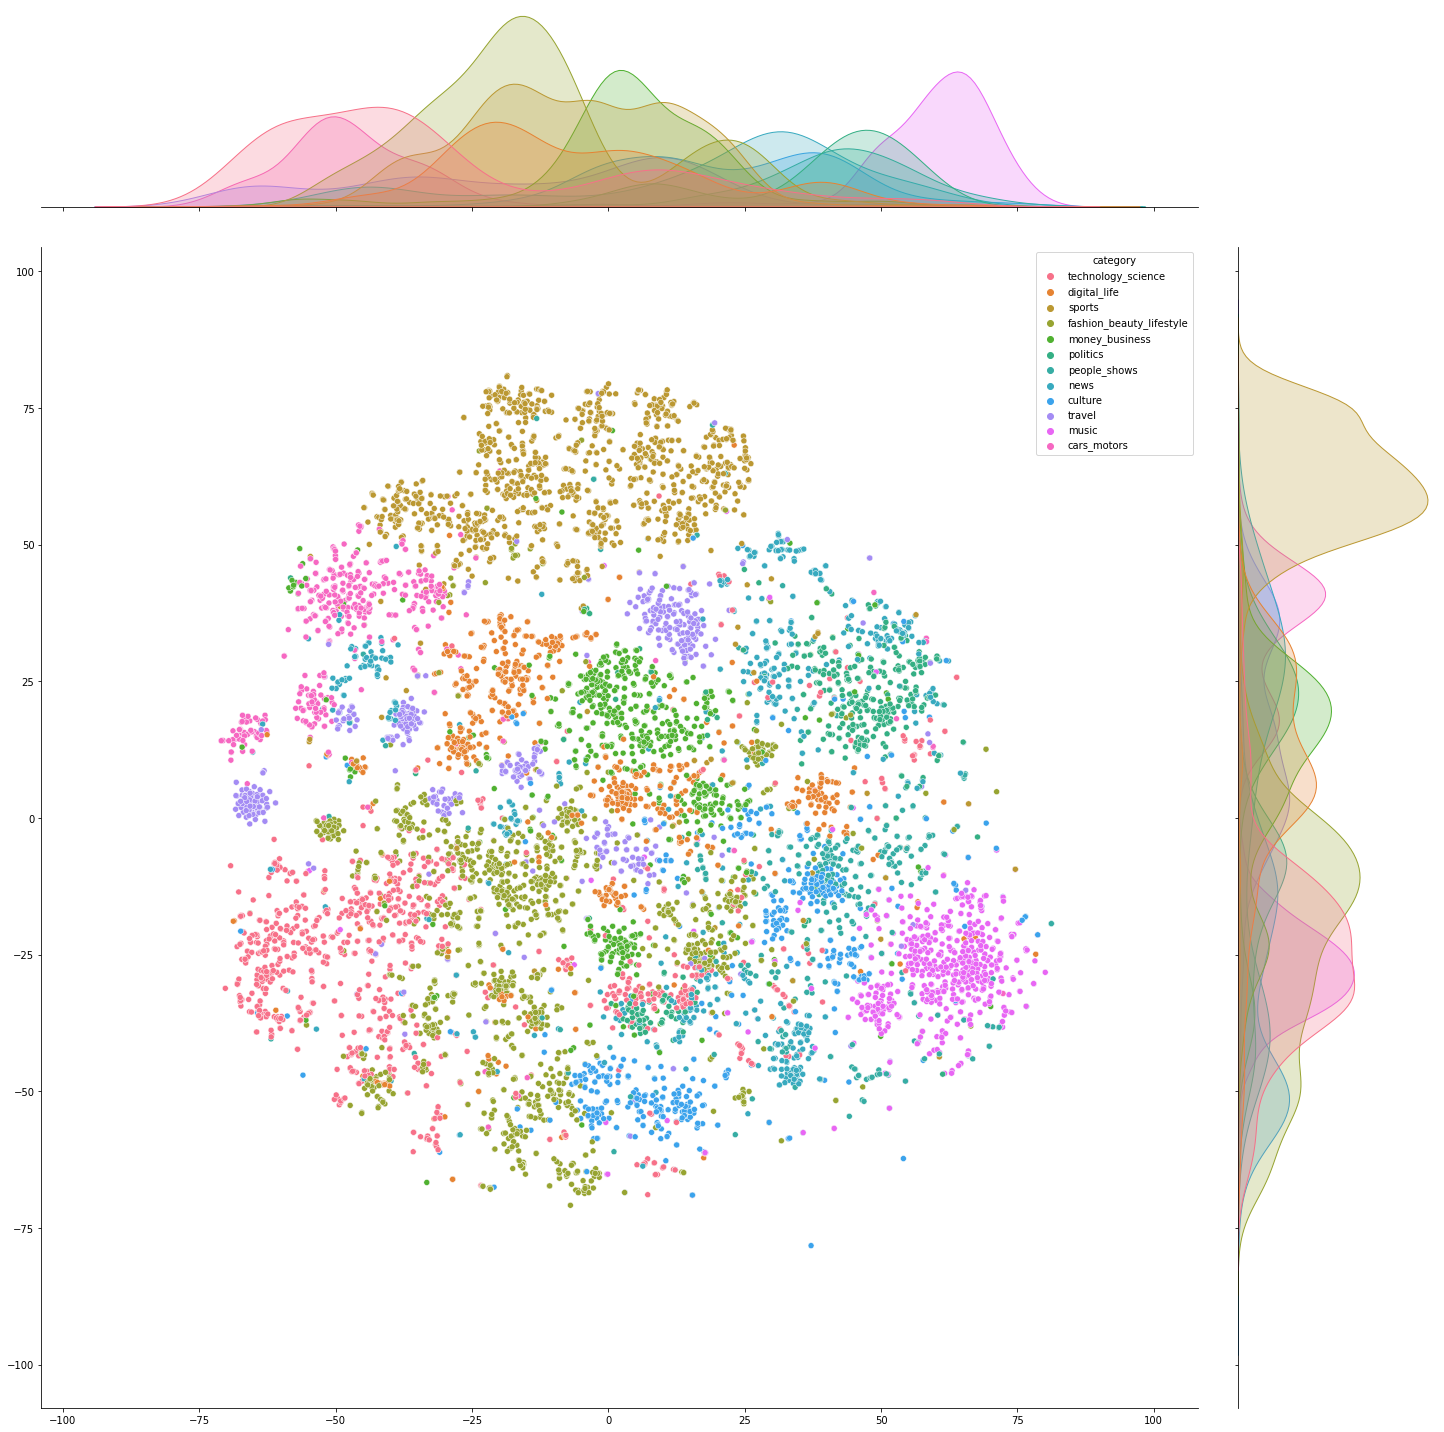

In [9]:
tsne = TSNE(perplexity=50.0).fit_transform(dtm)
sns.jointplot(data=df, x=tsne[:, 0], y=tsne[:, 1], hue='category', height=20)

Some categories, such as music, cars and sports are well defined. Fashion seems to be close to many different categories. News and people shows seem to be awfully close to each other. 

It seems that some categories will be easily separated, but other will require extra work.

# Model Training

Given its training speed and interpretability of its output, a linear SVM will be used to classify the word vectors into categories.

The hyperparameters of both the word vectorizer and the classification model will be fine tuned using GridSearchCV

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, df['category'], stratify=df['category'], test_size=0.25, random_state=42)

text_column = 'lemmatized_text'

candidate_params = {
    "tfidf__ngram_range": [(1, 2)],
    "tfidf__max_df": [0.25, 0.5, 1.0],
    "tfidf__min_df": [2, 10, 25],
    "model__C": [0.8, 1.0, 1.2],
}

best_params, pipe = find_best_parameters(X_train, y_train, text_column, candidate_params)
print('Best parameters:', best_params)

Total search time: 50.662568602001556
Best parameters: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 1.0, 'model__C': 1.0}


With the chosen parameters a definitive model will be trained. The results can be seen below:

                          precision    recall  f1-score   support

             cars_motors       0.90      0.97      0.93       117
                 culture       0.88      0.88      0.88       137
            digital_life       0.92      0.90      0.91       185
fashion_beauty_lifestyle       0.90      0.88      0.89       350
          money_business       0.93      0.90      0.91       183
                   music       0.93      0.99      0.96       142
                    news       0.81      0.82      0.82       162
            people_shows       0.81      0.82      0.81        92
                politics       0.86      0.86      0.86       107
                  sports       0.99      0.97      0.98       291
      technology_science       0.87      0.91      0.89       260
                  travel       0.95      0.90      0.92       136

                accuracy                           0.90      2162
               macro avg       0.90      0.90      0.90      2162
        

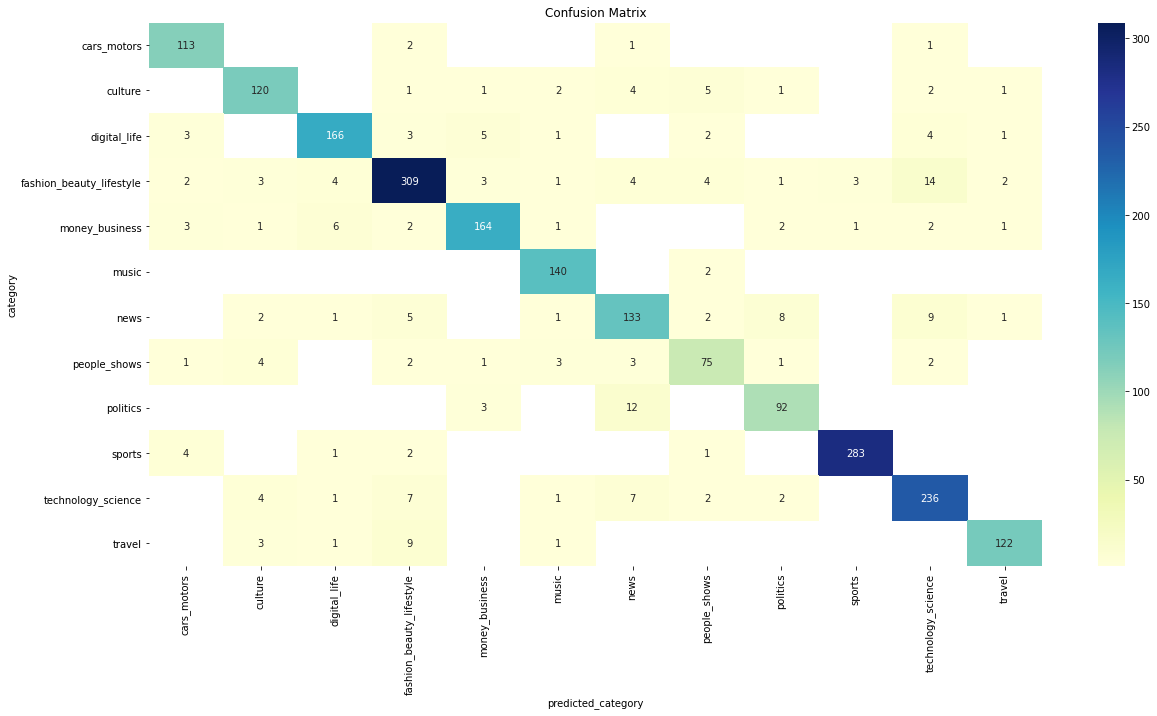

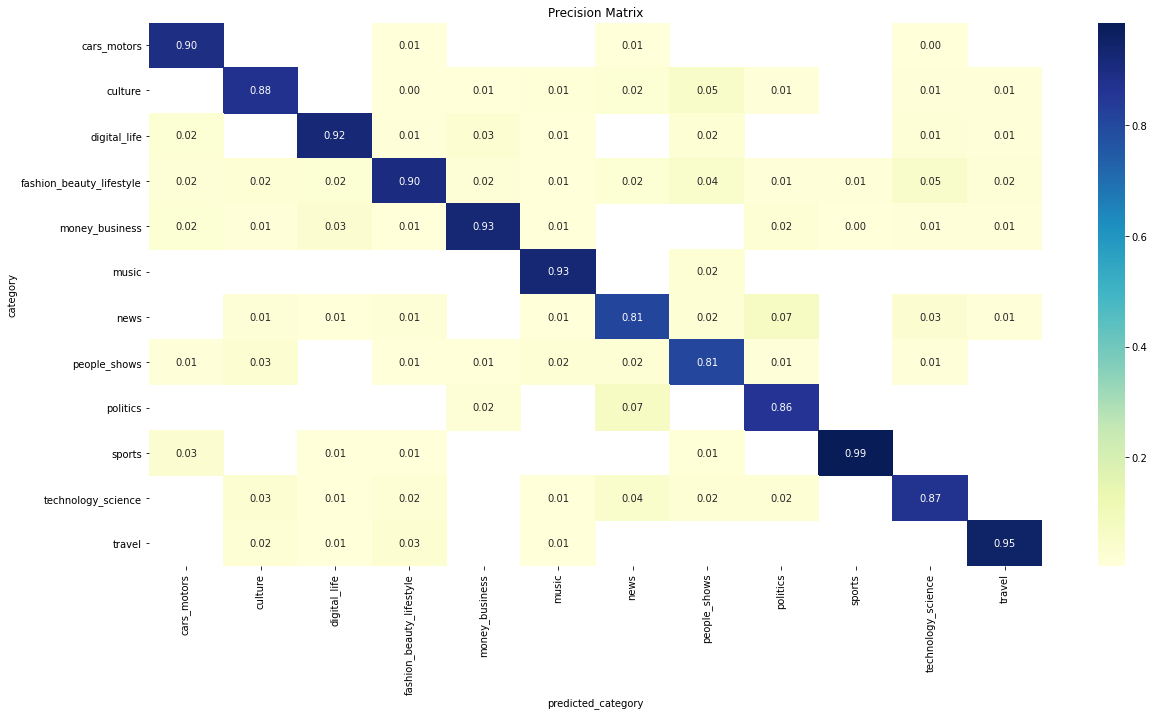

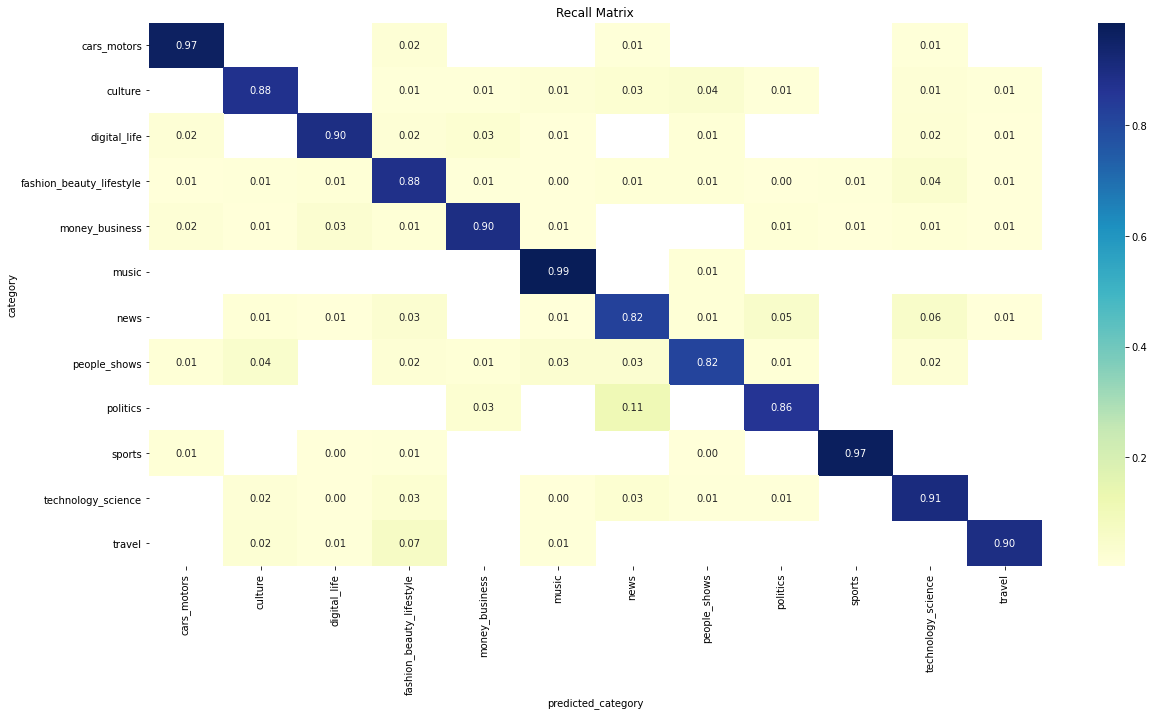

In [11]:
pipe.set_params(**best_params).fit(X_train[text_column], y_train)

predictions = pipe.predict(X_test[text_column])
report = classification_report(y_test, predictions)
print(report)

X_test['predicted_category'] = predictions

plot_confusion_matrices(X_test)

As expected, one of the most mixed categories are news and politics. Som examples can be seen below

In [12]:
X_test.loc[np.logical_and(X_test.category == 'news', X_test.predicted_category == 'politics'), ['title', 'text']].head()

,title,text
2463,Skye school closure plan falls,"The Highland Council’s controversial plan to close four primary schools on Skye and replace them with a new community school, appears to have been dealt a fatal blow by a sheriff. Education officials had advised councillors this would achieve the best and most sustainable educational provision for the north west of the island, given the small school rolls and poor condition of buildings. But the local authority’s decision to close Edinbane, Knockbreck and Struan primaries, and build a new larger facility at Dunvegan for their combined rolls, was called in by ministers in May last year. There was considerable parental opposition to the plans with claims that some pupils as young as four and a half, could be travelling much longer than the estimated 30 to 40 minutes council officials had estimated. It was referred to the School Closure Review Panel for assessment. The following month the panel, in its first decision, refused to allow the Highland Council to proceed with its plans. The local authority appealed the panel’s decision but a sheriff has now confirmed the panel’s decision. Councillor Drew Millar, Chair of the Education, Children & Adult Services Committee said: ""The council is disappointed at this decision. We have not yet had time to fully consider the written judgement, and will reflect further on these matters, once we have had an opportunity to do so."
5485,Donald Trump nominated for 2016 Nobel Peace Prize,"What do Donald Trump, Edward Snowden, Angela Merkel, Pope Francis, Greek islanders and an Afghan cycling group, have in common? Well, they are all nominated for the 2016 Nobel Peace Prize. The acerbic Republican presidential hopeful – who does not want Muslims to enter the US – was among the names thrown in for nominations. To put in perspective, the nominations do not necessarily mean it is already approved by the Nobel institute as the organisation accepts any valid submissions from across the world. Nobel-watcher Kristian Berg Harpviken , director of the Peace Research Institute in Oslo, said that Trump was nominated for the coveted award for ""his vigorous peace through strength ideology, used as a threat weapon of deterrence against radical Islam, ISIS, nuclear Iran and Communist China"". Trump""s nomination has been confirmed by the American nominator, according to Harpviken. The entire list of nominees is not revealed by the Nobel committee until 50 years later. But those who nominate the names are free to divulge the details. The last date to submit the nominations ended on 1 February and the Nobel prizes would normally be announced at 11am on the second Friday in October. The 2015 Peace prize was won by four Tunisian groups which were responsible for the transition to democracy in the highly unstable country. Also nominated for 2016 are whistleblower Edward Snowden, for revealing the mass surveillance by US""s National Security Agency (NSA). His disclosure has had a global resonance leading to political and legal reforms . Harpviken said that Snowden appears to be the strongest contender for this year. South African Archbishop Desmond Tutu, who himself won the Peace prize in 1984, had earlier revealed that he had made three nominations – Greece""s Good Samaritans known as the Aegean Solidarity Movement, Nuclear Age Peace Foundation, and the trio The Club of Rome, Herman Daly and Pope Francis. Tutu threw his weight behind the trio for ""significant contributions to global understanding of sustainable development""."
4556,EgyptAir MS804: A Cairo morgue gathers body parts but no answers on crashed flight,"In a small room off the main hallway of Cairo""s Zeinhom morgue, staff laid out a selection of hot and cold drinks. It was a small gesture but it was their way of trying to make the bleak task ahead a little bit easier. Over the coming days, family members of the 66 people killed aboard EgyptAir Flight MS804 will be asked to provide DNA samples to help ide

The new could really belong to either category. Now, for a stranger case, let's check cars_motors texts that were classified as fashion_beauty_lifestyle

In [14]:
X_test.loc[np.logical_and(X_test.category == 'cars_motors', X_test.predicted_category == 'fashion_beauty_lifestyle'), ['title', 'text']].head()

title  \
7872            One in three parents let their kids drive illegally   
1976  Atlantic gear test – Pip Hare tests kit on a 5,400nm crossing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

The first text mentions words such as family, parents and children. That could be a reason why the classifier got a wrong prediction


The model will be saved so it can be served in Django.

In [15]:
model_folder = 'model'

save_model(pipe, model_folder)

# Conclusions

The average accuracy of 91% is pretty good for a linear classifier approach. The accuracy could be furtherly increased by using an RNN that captures the subtle differences between news and politics categories. Much more data would be needed for this.

Honestly, I tried using word embeddings from Spacy but the classifiers didn't seem to appreciate them, they delivered slightly worse results and I couldn't inquire why, time is scarce already. In theory they should help once they are applied correctly.

Dimentionality reduction techniques like NMF, LDA or Truncated SVD did not seem to help in this particular case, so they are left out of the present report. However, a well applied reduction could greatly help in a bigger database.